- https://www.kaggle.com/raddar/paris-madness/notebook

In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

# Load the data

In [2]:
COMPETITION_YEAR = 2019

if COMPETITION_YEAR == 2019:
    tourney_detail = pd.read_csv('input/MDataFiles_Stage1/NCAATourneyDetailedResults.csv')
    seeds = pd.read_csv('input/MDataFiles_Stage1/NCAATourneySeeds.csv')
    regular_detail = pd.read_csv('input/MDataFiles_Stage1/Prelim2019_RegularSeasonDetailedResults.csv')
    submission = pd.read_csv('input/SampleSubmissionStage2.csv')
    
elif COMPETITION_YEAR == 2020:
    tourney_detail = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
    seeds = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneySeeds.csv')
    regular_detail = pd.read_csv('input/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
    submission = pd.read_csv('input/MSampleSubmissionStage1_2020.csv')

In [3]:
tourney_detail.shape

(1048, 34)

In [4]:
seeds.shape

(2286, 3)

In [5]:
regular_detail.shape

(87366, 34)

In [6]:
tourney_detail

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,2018,146,1242,85,1181,81,N,1,30,69,...,29,14,18,10,22,13,11,9,3,16
1044,2018,146,1437,71,1403,59,N,0,19,57,...,20,14,18,11,22,7,9,4,1,23
1045,2018,152,1276,69,1260,57,N,0,25,59,...,10,12,14,6,26,6,17,5,1,17
1046,2018,152,1437,95,1242,79,N,0,36,65,...,21,16,20,10,23,8,9,5,1,12


In [7]:
seeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2281,2019,Z12,1332
2282,2019,Z13,1414
2283,2019,Z14,1330
2284,2019,Z15,1159


In [8]:
regular_detail

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87361,2019,128,1412,70,1292,61,N,0,24,49,...,30,3,6,10,20,13,14,5,3,20
87362,2019,128,1417,79,1390,72,N,0,25,61,...,25,11,20,18,30,11,12,7,9,22
87363,2019,128,1425,78,1112,65,N,0,29,60,...,22,14,19,11,28,11,12,3,6,17
87364,2019,128,1439,71,1274,56,N,0,27,54,...,29,10,14,10,20,10,8,3,0,10


In [9]:
regular_detail.groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,
2003,74.808709,1285.591854,75.795061,1281.750867,63.756932,0.061308,26.299393,55.367851,6.695624,17.377166,...,18.720971,12.193674,18.055243,11.913345,21.115901,11.877816,15.602903,6.507582,2.768198,20.413128
2004,75.335156,1285.931306,74.971122,1280.900678,62.990155,0.071319,25.928681,55.069350,6.708160,17.570335,...,18.825202,12.025159,18.057755,11.844235,21.224021,11.870269,15.654999,6.493984,2.741413,20.322468
2005,75.042567,1286.067166,74.693690,1282.088770,62.635294,0.066524,25.975187,54.949305,6.769840,17.678503,...,18.922139,11.875722,17.767059,11.733690,21.038717,11.771551,15.490481,6.509733,2.806203,19.884492
2006,74.712634,1283.769182,74.587555,1285.425478,62.666597,0.073996,25.920538,54.881228,6.845281,17.821526,...,18.882279,11.807862,17.589027,11.762035,20.874711,11.833929,15.521127,6.368089,2.836872,19.679210
2007,71.676780,1286.476700,74.829467,1283.896887,62.761650,0.067618,25.896887,54.196907,7.043228,18.138608,...,19.453500,11.862978,17.645251,11.534404,20.671227,11.667460,15.218917,6.225858,2.760658,19.985524
2008,68.392020,1288.741817,74.962425,1281.907418,62.755375,0.072439,25.932597,54.543289,7.162309,18.386791,...,19.622119,11.805152,17.567306,11.340306,21.026148,11.578346,15.173155,6.171025,2.836529,19.803021
2009,70.963612,1287.680511,74.033721,1281.312250,61.980377,0.071633,25.724138,54.550200,6.749095,17.743189,...,18.787579,11.883978,17.740331,11.440846,21.195847,11.328062,14.696895,6.093161,2.777481,19.574776
2010,70.741212,1289.607638,74.652480,1279.997910,62.484325,0.063272,25.799734,54.756603,6.655330,17.520616,...,18.618659,12.432263,18.563177,11.568687,21.415162,11.194376,14.431693,6.137374,2.888087,19.872126
2011,70.881243,1285.244758,74.374190,1283.078727,62.470644,0.077964,25.600839,54.468547,6.733321,17.675562,...,18.551658,12.415364,18.471979,11.168319,21.326916,11.180518,14.131910,5.933283,2.961685,20.081395


In [10]:
tourney_detail.groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,
2003,139.156250,1283.343750,76.562500,1288.765625,65.546875,0.093750,27.703125,57.906250,6.640625,16.281250,...,19.968750,12.281250,17.796875,12.421875,21.171875,12.031250,13.828125,6.062500,3.281250,18.875000
2004,139.156250,1286.515625,75.500000,1300.640625,64.265625,0.046875,25.890625,54.531250,6.906250,17.500000,...,20.468750,11.781250,16.750000,11.734375,20.593750,12.296875,12.734375,6.015625,2.031250,19.843750
2005,139.156250,1306.031250,75.562500,1299.562500,65.375000,0.109375,26.281250,54.609375,6.953125,18.015625,...,19.734375,11.984375,17.234375,12.359375,20.984375,12.265625,13.687500,6.781250,2.343750,19.468750
2006,139.156250,1282.250000,73.203125,1291.500000,63.171875,0.109375,24.984375,54.093750,6.609375,18.015625,...,19.890625,11.031250,15.625000,11.859375,21.375000,12.187500,13.375000,6.171875,3.171875,19.406250
2007,139.156250,1320.593750,75.703125,1299.421875,63.578125,0.093750,25.515625,54.250000,7.421875,18.406250,...,19.984375,11.656250,16.875000,11.359375,20.406250,11.500000,12.468750,5.906250,2.843750,20.328125
2008,139.156250,1329.781250,77.218750,1292.046875,63.281250,0.093750,27.500000,55.453125,6.937500,17.375000,...,20.609375,12.281250,18.171875,11.578125,20.031250,10.890625,12.593750,6.171875,2.890625,19.093750
2009,139.156250,1300.187500,77.250000,1284.843750,64.343750,0.046875,27.062500,57.000000,6.453125,17.265625,...,20.250000,11.781250,16.953125,11.734375,21.109375,11.703125,12.593750,5.953125,3.234375,19.593750
2010,139.156250,1287.031250,74.031250,1313.937500,63.328125,0.109375,25.515625,55.218750,7.125000,18.609375,...,19.468750,12.015625,18.109375,12.062500,21.140625,11.421875,12.234375,6.140625,3.000000,19.125000
2011,138.955224,1270.089552,73.194030,1299.208955,61.910448,0.089552,25.537313,54.716418,7.179104,18.358209,...,19.805970,11.328358,16.089552,10.805970,21.492537,11.447761,11.656716,5.701493,2.820896,18.313433


In [11]:
# Check if all columns are the same between regular_detail and tourney_detail
all(regular_detail.columns == tourney_detail.columns)

True

# Data preparation!

In [12]:
regular_detail.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [13]:
# Swap the features of winning team and losing team
regular_detail_swap = regular_detail[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [14]:
regular_detail.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [15]:
regular_detail_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,WScore,WLoc,NumOT,LFGM,LFGA,...,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,68,N,0,22,53,...,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,...,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,...,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,...,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,...,14,11,13,17,22,12,14,4,4,20


In [16]:
# Change winning location: "Home" to "Away", "Away" to "Home"
regular_detail_swap.loc[regular_detail['WLoc'] == 'H', 'WLoc'] = 'A'
regular_detail_swap.loc[regular_detail['WLoc'] == 'A', 'WLoc'] = 'H'

# Change "WLoc" to "location"
regular_detail.columns.values[6] = 'location'
regular_detail_swap.columns.values[6] = 'location'

In [17]:
regular_detail.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,location,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [18]:
regular_detail_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,WScore,location,NumOT,LFGM,LFGA,...,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,68,N,0,22,53,...,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,...,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,...,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,...,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,...,14,11,13,17,22,12,14,4,4,20


In [19]:
regular_detail.columns = [column.replace('W','T1_').replace('L','T2_') for column in regular_detail.columns]
regular_detail_swap.columns = [column.replace('L','T1_').replace('W','T2_') for column in regular_detail.columns]

In [20]:
regular_detail.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [21]:
regular_detail_swap.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1328,62,1104,68,N,0,22,53,...,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,...,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,...,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,...,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,...,14,11,13,17,22,12,14,4,4,20


In [22]:
# Concat regular_detail and regular_detail_swap together
regular_data = pd.concat([regular_detail, regular_detail_swap]).sort_index().reset_index(drop = True)

In [23]:
regular_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1328,62,1104,68,N,0,22,53,...,14,11,18,14,24,13,23,7,1,22
2,2003,10,1393,63,1272,70,N,0,24,67,...,20,10,19,15,28,16,13,4,4,18
3,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
4,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174727,2019,128,1425,78,1112,65,N,0,29,60,...,22,14,19,11,28,11,12,3,6,17
174728,2019,128,1274,56,1439,71,N,0,19,56,...,27,6,7,8,28,17,10,4,3,15
174729,2019,128,1439,71,1274,56,N,0,27,54,...,29,10,14,10,20,10,8,3,0,10
174730,2019,128,1452,72,1328,71,N,0,27,71,...,12,11,13,5,31,12,8,6,1,15


### Make function to prepare data

In [24]:
def prepare_data(df):
    # Swap winnig team's columns and losing team's columns
    df_swap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    df_swap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    df_swap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    df_swap.columns.values[6] = 'location'    
      
    df.columns = [column.replace('W','T1_').replace('L','T2_') for column in df.columns]
    df_swap.columns = [column.replace('L','T1_').replace('W','T2_') for column in df_swap.columns]

    df_concat = pd.concat([df, df_swap]).reset_index(drop=True)
    
    # -1, 0, 1 encoding
    df_concat.loc[df_concat.location=='N','location'] = '0'
    df_concat.loc[df_concat.location=='H','location'] = '1'
    df_concat.loc[df_concat.location=='A','location'] = '-1'
    df_concat.location = df_concat.location.astype(int)
    
    df_concat['PointDiff'] = df_concat['T1_Score'] - df_concat['T2_Score']
    
    return df_concat

In [25]:
# Reload data ot put into the function
tourney_detail = pd.read_csv('input/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
regular_detail = pd.read_csv('input/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')

regular_data = prepare_data(regular_detail)
tourney_data = prepare_data(tourney_detail)

In [26]:
regular_data.shape

(175008, 35)

In [27]:
tourney_data.shape

(2230, 35)

In [28]:
regular_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,62,0,0,27,58,...,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,0,0,26,62,...,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,0,0,24,58,...,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,0,0,18,38,...,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,0,0,30,61,...,17,27,21,15,12,10,7,1,14,6


In [29]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,...,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,...,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,...,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,...,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,...,15,20,10,26,16,14,5,8,19,2


# Feature engineering

In [30]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [31]:
boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [32]:
season_team_boxscore_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_team_boxscore_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,...,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [33]:
season_team_boxscore_statistics.columns = [''.join(col).strip() for col in season_team_boxscore_statistics.columns.values]
season_team_boxscore_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,...,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [34]:
season_T1_boxscore_stat = season_team_boxscore_statistics.copy()
season_T2_boxscore_stat = season_team_boxscore_statistics.copy()

season_T1_boxscore_stat.columns = ["T1_" + column.replace("T1_","").replace("T2_","opponent_") for column in season_T1_boxscore_stat.columns]
season_T2_boxscore_stat.columns = ["T2_" + column.replace("T1_","").replace("T2_","opponent_") for column in season_T2_boxscore_stat.columns]
season_T1_boxscore_stat.columns.values[0] = "Season"
season_T2_boxscore_stat.columns.values[0] = "Season"

In [35]:
season_T1_boxscore_stat.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,...,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [36]:
season_T2_boxscore_stat.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,...,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [37]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,...,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,...,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,...,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,...,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,...,15,20,10,26,16,14,5,8,19,2


In [38]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


In [39]:
tourney_data = pd.merge(tourney_data, season_T1_boxscore_stat, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_T2_boxscore_stat, on = ['Season', 'T2_TeamID'], how = 'left')

In [40]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000


In [41]:
# Extract the last 14days statistics (132 - 14 = 118)
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
# Winning rate of each team according to the season
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [42]:
last14days_stats_T1

,Season,T1_TeamID,T1_win_ratio_14d
0,2003,1102,0.333333
1,2003,1103,0.333333
2,2003,1104,0.333333
3,2003,1105,0.000000
4,2003,1106,0.500000
...,...,...,...
5611,2019,1462,0.500000
5612,2019,1463,0.750000
5613,2019,1464,0.000000
5614,2019,1465,0.500000


In [43]:
last14days_stats_T2

,Season,T2_TeamID,T2_win_ratio_14d
0,2003,1102,0.333333
1,2003,1103,0.333333
2,2003,1104,0.333333
3,2003,1105,0.000000
4,2003,1106,0.500000
...,...,...,...
5611,2019,1462,0.500000
5612,2019,1463,0.750000
5613,2019,1464,0.000000
5614,2019,1465,0.500000


In [44]:
tourney_data.head(3)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655


In [45]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [46]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,146,1246,71,1120,77,26.606061,55.606061,6.030303,16.575758,...,8.323529,23.382353,10.764706,12.029412,17.588235,5.911765,3.676471,10.294118,0.750000,1.000000
2226,2019,146,1181,67,1277,68,30.500000,63.911765,7.264706,24.058824,...,7.264706,22.852941,11.029412,12.382353,10.264706,6.411765,2.941176,13.294118,0.800000,1.000000
2227,2019,152,1277,51,1403,61,27.764706,57.176471,8.294118,21.617647,...,6.343750,21.062500,10.125000,9.531250,15.656250,6.437500,2.468750,13.812500,1.000000,0.666667
2228,2019,152,1120,62,1438,63,27.029412,60.441176,11.411765,29.970588,...,5.812500,21.406250,9.000000,8.718750,11.000000,5.187500,2.750000,16.781250,1.000000,0.750000


In [47]:
regular_data.head(3)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,62,0,0,27,58,...,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,0,0,26,62,...,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,0,0,24,58,...,14,23,31,22,9,12,2,5,23,12


In [48]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)

In [49]:
regular_season_effects

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1266,1437,12,1
3,2003,1296,1457,6,1
4,2003,1400,1208,6,1
...,...,...,...,...,...
175003,2019,1222,1153,-12,0
175004,2019,1426,1209,-9,0
175005,2019,1276,1277,-5,0
175006,2019,1382,1387,-2,0


In [50]:
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness

,Season,TeamID_x,TeamID_y
0,1985,1207,1207
1,1985,1207,1210
2,1985,1207,1228
3,1985,1207,1260
4,1985,1207,1374
...,...,...,...
149397,2019,1205,1332
149398,2019,1205,1414
149399,2019,1205,1330
149400,2019,1205,1159


In [51]:
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)

# Extract tourney result from all result (including regular season)
# Default how='inner'
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1323,1237,44,1
3,2003,1242,1221,24,1
4,2003,1390,1462,1,1
...,...,...,...,...,...
9909,2019,1280,1397,-17,0
9910,2019,1280,1397,-7,0
9911,2019,1397,1120,-4,0
9912,2019,1397,1120,-20,0


In [52]:
formula = 'win~-1+T1_TeamID+T2_TeamID'
glm = sm.GLM.from_formula(formula=formula, 
                          data=regular_season_effects.loc[regular_season_effects.Season==2014,:], 
                          family=sm.families.Binomial()).fit()

glm

C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


In [53]:
glm.params

T1_TeamID[1107]     -22.629169
T1_TeamID[1110]     -58.699186
T1_TeamID[1112]      19.945203
T1_TeamID[1113]      17.976763
T1_TeamID[1124]      19.056191
                       ...    
T2_TeamID[T.1454]    17.886557
T2_TeamID[T.1455]   -58.408140
T2_TeamID[T.1458]   -19.679487
T2_TeamID[T.1459]    17.772110
T2_TeamID[T.1462]   -17.915977
Length: 135, dtype: float64

In [54]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,146,1246,71,1120,77,26.606061,55.606061,6.030303,16.575758,...,8.323529,23.382353,10.764706,12.029412,17.588235,5.911765,3.676471,10.294118,0.750000,1.000000
2226,2019,146,1181,67,1277,68,30.500000,63.911765,7.264706,24.058824,...,7.264706,22.852941,11.029412,12.382353,10.264706,6.411765,2.941176,13.294118,0.800000,1.000000
2227,2019,152,1277,51,1403,61,27.764706,57.176471,8.294118,21.617647,...,6.343750,21.062500,10.125000,9.531250,15.656250,6.437500,2.468750,13.812500,1.000000,0.666667
2228,2019,152,1120,62,1438,63,27.029412,60.441176,11.411765,29.970588,...,5.812500,21.406250,9.000000,8.718750,11.000000,5.187500,2.750000,16.781250,1.000000,0.750000


In [55]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [56]:
seeds['Seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID
0,1985,1,1207
1,1985,2,1210
2,1985,3,1228
3,1985,4,1260
4,1985,5,1374


In [57]:
seeds_T1 = seeds[['Season','TeamID','Seed']].copy()
seeds_T2 = seeds[['Season','TeamID','Seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [58]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [59]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,16,16,0
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,1,16,-15
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,10,7,3
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,11,6,5
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,8,9,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,146,1246,71,1120,77,26.606061,55.606061,6.030303,16.575758,...,12.029412,17.588235,5.911765,3.676471,10.294118,0.750000,1.000000,2,5,-3
2226,2019,146,1181,67,1277,68,30.500000,63.911765,7.264706,24.058824,...,12.382353,10.264706,6.411765,2.941176,13.294118,0.800000,1.000000,1,2,-1
2227,2019,152,1277,51,1403,61,27.764706,57.176471,8.294118,21.617647,...,9.531250,15.656250,6.437500,2.468750,13.812500,1.000000,0.666667,2,3,-1
2228,2019,152,1120,62,1438,63,27.029412,60.441176,11.411765,29.970588,...,8.718750,11.000000,5.187500,2.750000,16.781250,1.000000,0.750000,5,1,4


# Modeling

In [60]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    2230.000000
mean        0.000000
std        14.342819
min       -56.000000
25%       -10.000000
50%         0.000000
75%        10.000000
max        56.000000
dtype: float64

In [61]:
season_T1_boxscore_stat

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,...,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5829,2019,1462,26.121212,55.848485,7.000000,21.030303,10.424242,14.787879,13.454545,5.424242,...,25.727273,59.363636,8.878788,25.090909,9.818182,14.363636,11.060606,7.000000,3.030303,1.272727
5830,2019,1463,29.821429,60.107143,7.785714,20.821429,8.678571,17.000000,13.250000,5.750000,...,26.000000,63.035714,7.500000,24.071429,9.607143,12.678571,11.214286,7.107143,2.964286,7.178571
5831,2019,1464,26.833333,63.633333,9.566667,28.000000,12.966667,13.633333,13.133333,6.100000,...,27.566667,58.466667,7.533333,22.033333,9.800000,14.133333,11.500000,5.900000,3.333333,-5.733333
5832,2019,1465,26.038462,59.038462,8.807692,25.230769,10.076923,10.615385,12.500000,4.346154,...,25.769231,59.038462,6.576923,18.384615,10.769231,11.230769,10.807692,5.538462,2.615385,0.269231


In [62]:
season_T1_boxscore_stat.columns

Index(['Season', 'T1_TeamID', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean',
       'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean',
       'T1_PFmean', 'T1_opponent_FGMmean', 'T1_opponent_FGAmean',
       'T1_opponent_FGM3mean', 'T1_opponent_FGA3mean', 'T1_opponent_ORmean',
       'T1_opponent_Astmean', 'T1_opponent_TOmean', 'T1_opponent_Stlmean',
       'T1_opponent_Blkmean', 'T1_PointDiffmean'],
      dtype='object')

In [63]:
seeds_T1.columns

Index(['Season', 'T1_TeamID', 'T1_seed'], dtype='object')

In [64]:
features = list(season_T1_boxscore_stat.columns[2:999]) + \
    list(season_T2_boxscore_stat.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"]

len(features)

43

In [65]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,...,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,16,16,0
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,...,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,1,16,-15
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,...,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,10,7,3
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,...,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,11,6,5
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,...,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,8,9,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,146,1246,71,1120,77,26.606061,55.606061,6.030303,16.575758,...,12.029412,17.588235,5.911765,3.676471,10.294118,0.750000,1.000000,2,5,-3
2226,2019,146,1181,67,1277,68,30.500000,63.911765,7.264706,24.058824,...,12.382353,10.264706,6.411765,2.941176,13.294118,0.800000,1.000000,1,2,-1
2227,2019,152,1277,51,1403,61,27.764706,57.176471,8.294118,21.617647,...,9.531250,15.656250,6.437500,2.468750,13.812500,1.000000,0.666667,2,3,-1
2228,2019,152,1120,62,1438,63,27.029412,60.441176,11.411765,29.970588,...,8.718750,11.000000,5.187500,2.750000,16.781250,1.000000,0.750000,5,1,4


In [66]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [67]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [68]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [69]:
xgb_cv = []
repeat_cv = 10 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:11.2773+0.0770442	test-mae:11.2862+0.308386
[50]	train-mae:8.51087+0.0588362	test-mae:8.9285+0.26881
[100]	train-mae:8.0679+0.0674561	test-mae:8.84844+0.241949
[150]	train-mae:7.74956+0.065031	test-mae:8.85279+0.232707
Fold repeater 1
[0]	train-mae:11.277+0.0504096	test-mae:11.2838+0.205236
[50]	train-mae:8.50694+0.0734411	test-mae:8.92089+0.308282
[100]	train-mae:8.06542+0.0673077	test-mae:8.83432+0.306881
Fold repeater 2
[0]	train-mae:11.2768+0.100799	test-mae:11.2879+0.407623
[50]	train-mae:8.49885+0.0593809	test-mae:8.94473+0.21725
[100]	train-mae:8.05592+0.0611339	test-mae:8.85953+0.194706
Fold repeater 3
[0]	train-mae:11.2791+0.072229	test-mae:11.2849+0.309136
[50]	train-mae:8.51191+0.0501213	test-mae:8.90212+0.189271
[100]	train-mae:8.07325+0.0443351	test-mae:8.80351+0.220027
[150]	train-mae:7.76715+0.0392152	test-mae:8.79596+0.231463
Fold repeater 4
[0]	train-mae:11.2772+0.0809835	test-mae:11.2833+0.337487
[50]	train-mae:8.50182+0.0900237	test-mae:

In [70]:
xgb_cv

[     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
 0         11.277266       0.077044      11.286195      0.308386
 1         11.091688       0.074248      11.111637      0.310903
 2         10.917788       0.074940      10.946320      0.311072
 3         10.753952       0.074454      10.790402      0.311969
 4         10.600640       0.075634      10.644934      0.313492
 ..              ...            ...            ...           ...
 126        7.892749       0.066388       8.848916      0.241785
 127        7.885873       0.065477       8.846613      0.241169
 128        7.879622       0.065307       8.845528      0.240276
 129        7.873767       0.065379       8.845400      0.239971
 130        7.867257       0.065507       8.844408      0.240825
 
 [131 rows x 4 columns],
      train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
 0         11.277042       0.050410      11.283787      0.205236
 1         11.091455       0.047515      11.104562      0.21457

In [71]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([130, 108, 109, 175, 116, 116, 109, 106, 118, 121],
 [8.8444082,
  8.828774,
  8.855236,
  8.7877898,
  8.8161156,
  8.8435574,
  8.8251226,
  8.8269094,
  8.8348786,
  8.8315126])

In [72]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [73]:
y

0        8
1       29
2       13
3        6
4        2
        ..
2225    -6
2226    -1
2227   -10
2228    -1
2229    -8
Length: 2230, dtype: int64

In [74]:
oof_preds

[0       -1.250490
 1       18.486107
 2       -3.538105
 3      -12.723864
 4       -1.019073
           ...    
 2225     1.455663
 2226     4.690197
 2227    -1.486400
 2228    -2.739776
 2229    -1.628000
 Length: 2230, dtype: float64, 0       -0.794867
 1       17.079212
 2       -3.779388
 3      -11.897171
 4       -0.204272
           ...    
 2225     1.510603
 2226     3.771709
 2227     0.113575
 2228    -3.183249
 2229     0.250638
 Length: 2230, dtype: float64, 0       -2.751858
 1       18.861757
 2       -4.670548
 3      -10.704436
 4       -0.465774
           ...    
 2225    -0.954521
 2226     4.186148
 2227    -0.319289
 2228    -3.269241
 2229    -1.319515
 Length: 2230, dtype: float64, 0       -0.504125
 1       16.968744
 2       -5.276857
 3      -13.665861
 4       -1.467558
           ...    
 2225    -0.055045
 2226     8.720374
 2227    -0.487181
 2228    -2.405586
 2229     1.082800
 Length: 2230, dtype: float64, 0       -0.146540
 1       18.938025
 2    

In [75]:
oof_preds[0]

0       -1.250490
1       18.486107
2       -3.538105
3      -12.723864
4       -1.019073
          ...    
2225     1.455663
2226     4.690197
2227    -1.486400
2228    -2.739776
2229    -1.628000
Length: 2230, dtype: float64

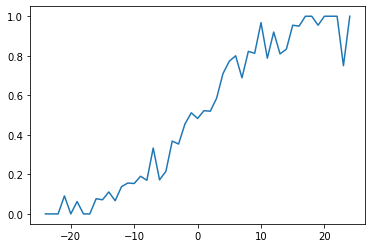

In [76]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [77]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5461360917891969
logloss of cvsplit 1: 0.5442901824416793
logloss of cvsplit 2: 0.5439696183578611
logloss of cvsplit 3: 0.542435712931517
logloss of cvsplit 4: 0.5430913844807532
logloss of cvsplit 5: 0.5450515725532671
logloss of cvsplit 6: 0.5432915708744843
logloss of cvsplit 7: 0.5403927028843265
logloss of cvsplit 8: 0.5440871911639212
logloss of cvsplit 9: 0.5422605211969571


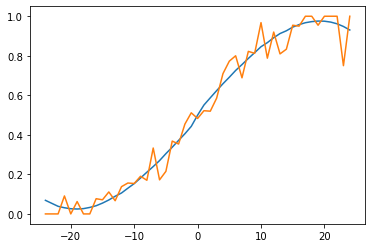

In [78]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [79]:
plot_df

,pred_int,spline,label
0,-24,0.068733,0.000000
1,-22,0.038444,0.000000
2,-21,0.031154,0.090909
3,-20,0.026191,0.000000
4,-19,0.024791,0.062500
5,-18,0.026736,0.000000
6,-17,0.032808,0.000000
7,-16,0.041422,0.076923
8,-15,0.054664,0.071429
9,-14,0.070558,0.111111


In [80]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5461269571786991
adjusted logloss of cvsplit 1: 0.5442402835584559
adjusted logloss of cvsplit 2: 0.54397380069425
adjusted logloss of cvsplit 3: 0.5425273783663331
adjusted logloss of cvsplit 4: 0.543117753028998
adjusted logloss of cvsplit 5: 0.5449959999343024
adjusted logloss of cvsplit 6: 0.5433318010780157
adjusted logloss of cvsplit 7: 0.5404908719298351
adjusted logloss of cvsplit 8: 0.5441017438405034
adjusted logloss of cvsplit 9: 0.5422483288756373


In [81]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.571834531954007
adjusted logloss of cvsplit 1: 0.570132081370163
adjusted logloss of cvsplit 2: 0.5697604573144504
adjusted logloss of cvsplit 3: 0.568235913554593
adjusted logloss of cvsplit 4: 0.5689777785905322
adjusted logloss of cvsplit 5: 0.5709252457865376
adjusted logloss of cvsplit 6: 0.5692238079395225
adjusted logloss of cvsplit 7: 0.5663782004616024
adjusted logloss of cvsplit 8: 0.5699412535465468
adjusted logloss of cvsplit 9: 0.5679899231495955


In [82]:
spline_model

In [83]:
spline_fit

array([0.4612436 , 1.        , 0.37914106, ..., 0.45501312, 0.34780524,
       0.4774543 ])

In [84]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
).sort_values(['Season'])

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,...,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
2129,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,...,13.580645,14.322581,6.258065,2.806452,1.516129,1.0,1.0,1,16,-15
1014,2018,137,1420,74,1438,54,25.612903,58.451613,9.838710,25.774194,...,8.848485,12.727273,3.878788,2.636364,14.151515,1.0,1.0,16,1,15


In [85]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5441661043849382
adjusted logloss of cvsplit 1: 0.5424636538010941
adjusted logloss of cvsplit 2: 0.5420573992889716
adjusted logloss of cvsplit 3: 0.5404974781463555
adjusted logloss of cvsplit 4: 0.5413093510214634
adjusted logloss of cvsplit 5: 0.5432568182174686
adjusted logloss of cvsplit 6: 0.5414320738036338
adjusted logloss of cvsplit 7: 0.5387097728925334
adjusted logloss of cvsplit 8: 0.5422728259774778
adjusted logloss of cvsplit 9: 0.5403214955805266


In [86]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.5413774897928653
adjusted logloss of cvsplit 1: 0.5398649510447068
adjusted logloss of cvsplit 2: 0.5393235983880846
adjusted logloss of cvsplit 3: 0.5376271377085018
adjusted logloss of cvsplit 4: 0.5387238666637191
adjusted logloss of cvsplit 5: 0.5404825159631453
adjusted logloss of cvsplit 6: 0.5387338221122334
adjusted logloss of cvsplit 7: 0.5363178729769157
adjusted logloss of cvsplit 8: 0.5396551551897172
adjusted logloss of cvsplit 9: 0.5377165879502521


season
2003    0.541751
2004    0.511340
2005    0.496268
2006    0.566128
2007    0.447941
2008    0.469912
2009    0.480845
2010    0.562505
2011    0.601150
2012    0.581613
2013    0.594592
2014    0.601132
2015    0.529624
2016    0.561001
2017    0.507971
2018    0.595087
2019    0.503309
dtype: float64

# Submission time!

In [97]:
submission

,ID,Pred
0,2019_1101_1113,0.5
1,2019_1101_1120,0.5
2,2019_1101_1124,0.5
3,2019_1101_1125,0.5
4,2019_1101_1133,0.5
...,...,...
2273,2019_1449_1459,0.5
2274,2019_1449_1463,0.5
2275,2019_1458_1459,0.5
2276,2019_1458_1463,0.5


In [98]:
submission["Season"] = submission["ID"].apply(lambda x: x[:4]).astype(int)
submission["T1_TeamID"] = submission["ID"].apply(lambda x: x[5:9]).astype(int)
submission["T2_TeamID"] = submission["ID"].apply(lambda x: x[10:14]).astype(int)
submission

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2019_1101_1113,0.5,2019,1101,1113
1,2019_1101_1120,0.5,2019,1101,1120
2,2019_1101_1124,0.5,2019,1101,1124
3,2019_1101_1125,0.5,2019,1101,1125
4,2019_1101_1133,0.5,2019,1101,1133
...,...,...,...,...,...
2273,2019_1449_1459,0.5,2019,1449,1459
2274,2019_1449_1463,0.5,2019,1449,1463
2275,2019_1458_1459,0.5,2019,1458,1459
2276,2019_1458_1463,0.5,2019,1458,1463


In [99]:
submission = pd.merge(submission, season_T1_boxscore_stat, on = ['Season', 'T1_TeamID'])
submission = pd.merge(submission, season_T2_boxscore_stat, on = ['Season', 'T2_TeamID'])
submission = pd.merge(submission, seeds_T1, on = ['Season', 'T1_TeamID'])
submission = pd.merge(submission, seeds_T2, on = ['Season', 'T2_TeamID'])
submission = pd.merge(submission, last14days_stats_T1, on = ['Season', 'T1_TeamID'])
submission = pd.merge(submission, last14days_stats_T2, on = ['Season', 'T2_TeamID'])
submission["Seed_diff"] = submission["T1_seed"] - submission["T2_seed"]

In [100]:
submission

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,...,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2019_1101_1113,0.5,2019,1101,1113,25.344828,55.241379,7.241379,18.896552,9.068966,...,13.281250,13.906250,6.343750,3.468750,4.750000,15,11,1.000000,0.666667,4
1,2019_1101_1120,0.5,2019,1101,1120,25.344828,55.241379,7.241379,18.896552,9.068966,...,12.029412,17.588235,5.911765,3.676471,10.294118,15,5,1.000000,1.000000,10
2,2019_1113_1120,0.5,2019,1113,1120,26.593750,59.468750,7.250000,21.250000,12.156250,...,12.029412,17.588235,5.911765,3.676471,10.294118,11,5,0.666667,1.000000,6
3,2019_1101_1124,0.5,2019,1101,1124,25.344828,55.241379,7.241379,18.896552,9.068966,...,12.843750,12.406250,5.968750,4.218750,4.468750,15,9,1.000000,0.000000,6
4,2019_1113_1124,0.5,2019,1113,1124,26.593750,59.468750,7.250000,21.250000,12.156250,...,12.843750,12.406250,5.968750,4.218750,4.468750,11,9,0.666667,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2019_1438_1463,0.5,2019,1438,1463,25.625000,53.593750,8.468750,20.718750,8.875000,...,12.678571,11.214286,7.107143,2.964286,7.178571,1,14,0.750000,0.750000,-13
2274,2019_1439_1463,0.5,2019,1439,1463,25.750000,54.156250,9.593750,24.343750,8.906250,...,12.678571,11.214286,7.107143,2.964286,7.178571,4,14,0.500000,0.750000,-10
2275,2019_1449_1463,0.5,2019,1449,1463,24.558824,54.264706,7.470588,21.588235,9.470588,...,12.678571,11.214286,7.107143,2.964286,7.178571,9,14,0.600000,0.750000,-5
2276,2019_1458_1463,0.5,2019,1458,1463,25.878788,57.121212,7.121212,19.454545,8.151515,...,12.678571,11.214286,7.107143,2.964286,7.178571,5,14,0.750000,0.750000,-9


In [101]:
X_submission = submission[features].values
dtest = xgb.DMatrix(X_submission)

In [102]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [103]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
submission["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

submission.loc[(submission.T1_seed==1) & (submission.T2_seed==16), 'Pred'] = 1.0
submission.loc[(submission.T1_seed==16) & (submission.T2_seed==1), 'Pred'] = 0.0

if COMPETITION_YEAR == 2019:
    submission[['ID','Pred']].to_csv("submission-Men-2019.csv", index = None)
elif COMPETITION_YEAR == 2020:
    submission[['ID','Pred']].to_csv("submission-Men-2020.csv", index = None)

Text(0.5, 1.0, 'Prediction Distribution')

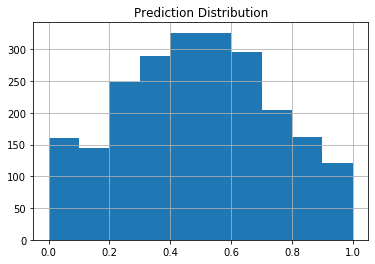

In [106]:
submission['Pred'].hist()
plt.title('Prediction Distribution');